In [1]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import os
from numpy import float32
import gc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
os.getcwd()

In [6]:
promoted_content = pd.read_csv('promoted_content.csv')
document_category = pd.read_csv('documents_categories.csv')
document_topic = pd.read_csv('documents_topics.csv')
document_entity = pd.read_csv('documents_entities.csv')
events_data = pd.read_csv('events.csv')
clicks_train  = pd.read_csv('clicks_train.csv')
clicks_test = pd.read_csv('clicks_test.csv')

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
clicks_train.shape

In [ ]:
clicks_test.shape

In [7]:
def splitDataFrameIntoSmaller(dfs, chunkSize = 15000000):
    dataframes = list()
    chunk_number = len(dfs) // chunkSize + 1
    for i in range(chunk_number):
        dataframes.append(dfs[i*chunkSize:(i+1)*chunkSize])
    return dataframes

In [8]:
split_train_frame = splitDataFrameIntoSmaller(clicks_train)

In [9]:
chunk_frame = split_train_frame[0]

In [ ]:
chunk_frame.head()

# Events - File 0

In [ ]:
merged_df_with_Event = pd.DataFrame(events_data)

In [ ]:
merged_df_with_Event.drop(['uuid','timestamp','document_id'],axis=1,inplace=True)

In [ ]:
merged_df_with_Event['Country']=merged_df_with_Event['geo_location'].str[0:2]

In [ ]:
merged_df_with_Event.drop(['geo_location'],axis=1,inplace=True)

In [ ]:
merged_df_with_Event.head(1)

In [ ]:
merged_df_with_Events = pd.merge(chunk_frame,merged_df_with_Event,how='left',on=(['display_id']))

In [ ]:
merged_df_with_Events['Country'] = pd.Categorical.from_array(merged_df_with_Events.Country).labels
merged_df_with_Events = merged_df_with_Events.query("Country == Country")

In [ ]:
merged_df_with_Events['platform'] = pd.Categorical.from_array(merged_df_with_Events.platform).labels
merged_df_with_Events['platform'] = pd.to_numeric(merged_df_with_Events['platform'], errors='ignore')

In [ ]:
merged_df_with_Events.head(1)

# Promoted Content - File 1

In [ ]:
merged_df = pd.merge(merged_df_with_Events,promoted_content,how='left',on='ad_id')

# Document Category - File 2

In [ ]:
average_category_confidenceLevel = pd.DataFrame(document_category.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Cat = pd.merge(merged_df,average_category_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Cat.to_csv('merged_df_with_CL_Cat.csv',index=None)

In [ ]:
merged_df_with_CL_Cat = merged_df_with_CL_Cat[np.isfinite(merged_df_with_CL_Cat['confidence_level'])]

In [ ]:
merged_df_with_CL_Cat['confidence_level'] = merged_df_with_CL_Cat['confidence_level'].map('{:,.3f}'.format)

In [ ]:
merged_df_with_CL_Cat[['confidence_level']] = merged_df_with_CL_Cat[['confidence_level']].astype(float)

# Document Topics - File 3

In [ ]:
average_topic_confidenceLevel = pd.DataFrame(document_topic.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Top = pd.merge(merged_df_with_CL_Cat,average_topic_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Top = merged_df_with_CL_Top[np.isfinite(merged_df_with_CL_Top['confidence_level_y'])]

In [ ]:
merged_df_with_CL_Top['confidence_level_y'] = merged_df_with_CL_Top['confidence_level_y'].map('{:,.3f}'.format)

In [ ]:
merged_df_with_CL_Top[['confidence_level_y']] = merged_df_with_CL_Top[['confidence_level_y']].astype(float)

# Document Entities - File 4

In [ ]:
average_entity_confidenceLevel = pd.DataFrame(document_entity.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Ent = pd.merge(merged_df_with_CL_Top,average_entity_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Ent.to_csv("merged_df_with_CL_Ent.csv")

In [ ]:
gc.collect()

In [11]:
merged_df_with_CL_Ent = pd.read_csv("merged_df_with_CL_Ent.csv")

In [12]:
merged_df_with_CL_Ent = merged_df_with_CL_Ent[np.isfinite(merged_df_with_CL_Ent['confidence_level'])]

In [13]:
merged_df_with_CL_Ent['confidence_level'] = merged_df_with_CL_Ent['confidence_level'].map('{:,.3f}'.format)

In [14]:
merged_df_with_CL_Ent[['confidence_level']] = merged_df_with_CL_Ent[['confidence_level']].astype(float)

In [15]:
merged_df_with_CL_Ent[['platform']] = merged_df_with_CL_Ent[['platform']].astype(int)

In [16]:
merged_df_with_CL_Ent.drop(['Unnamed: 0'],axis=1,inplace=True)

In [17]:
merged_df_with_CL_Ent.shape

(12977781, 11)

In [ ]:
merged_df_with_CL_Ent.to_csv("Document_Metadata.csv", index=False)

In [ ]:
document_metadata = pd.read_csv("Document_Metadata.csv")

In [ ]:
document_metadata.head()

# Model Creation

In [18]:
X = [x for x in merged_df_with_CL_Ent.columns if x not in ['display_id','clicked']]
x = merged_df_with_CL_Ent[X]

In [19]:
Y = ['clicked']
y = merged_df_with_CL_Ent[Y]
y = np.ravel(y)

In [20]:
Xtrain, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)

In [21]:
model = LogisticRegression(random_state=1,C=1e9,solver='sag', max_iter=200, n_jobs=3)

In [22]:
train_model = model.fit(Xtrain,y_train)

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [23]:
print(model.score(Xtrain,y_train))

0.806508839394


In [24]:
pred = train_model.predict_proba(X_test)

In [25]:
preds = model.predict_proba(X_test)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

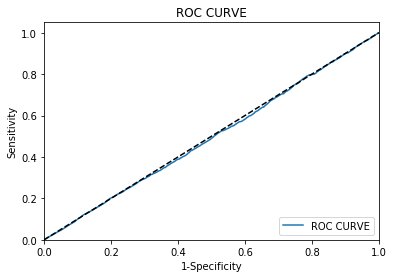

In [26]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()